# Exploratory Data Analysis

Use a combination of visualizations (heatmaps, correlation matrices, scatterplots, bar charts etc.) to discover trends, patterns, and clusters in the data. Then, interpret these findings to aid in feature selection for the final model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./datasets/train.csv')

In [3]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [4]:
df.shape

(2051, 81)

---

## Examine the distribution of all features
Start by dividing columns into lists of numeric and categorical features.

In [5]:
numeric = []
categorical = []

numeric = [col for col in df.columns if df.dtypes[col]==int or df.dtypes[col]==float]
categorical = [col for col in df.columns if df.dtypes[col]==object]

In [6]:
df[categorical].isnull().sum() # check for null values

MS Zoning            0
Street               0
Alley             1911
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        22
Exter Qual           0
Exter Cond           0
Foundation           0
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin Type 2      56
Heating              0
Heating QC           0
Central Air          0
Electrical           0
Kitchen Qual         0
Functional           0
Fireplace Qu      1000
Garage Type        113
Garage Finish      114
Garage Qual        114
Garage Cond        114
Paved Drive          0
Pool QC           2042
Fence             1651
Misc Feature      1986
Sale Type            0
dtype: int64

In [7]:
# Add a few interaction columns regarding square footage, one of the primary indicators of price
df['Total SF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
df['Price per SF'] = df['SalePrice']/df['Total SF']

Functions to programmatically generate histograms:

In [8]:
# Function that returns a column free of null values
def clean_col(Series):
    if np.nan in set(Series):
        return Series.dropna()
    else:
        return Series

In [9]:
# Function that prints a histogram of a column
def hist_plot_cols(list, i):
    plt.figure(figsize=(6, 4));
    plt.title(list[i]);
    plt.hist(clean_col(df[list[i]]));
    plt.show();

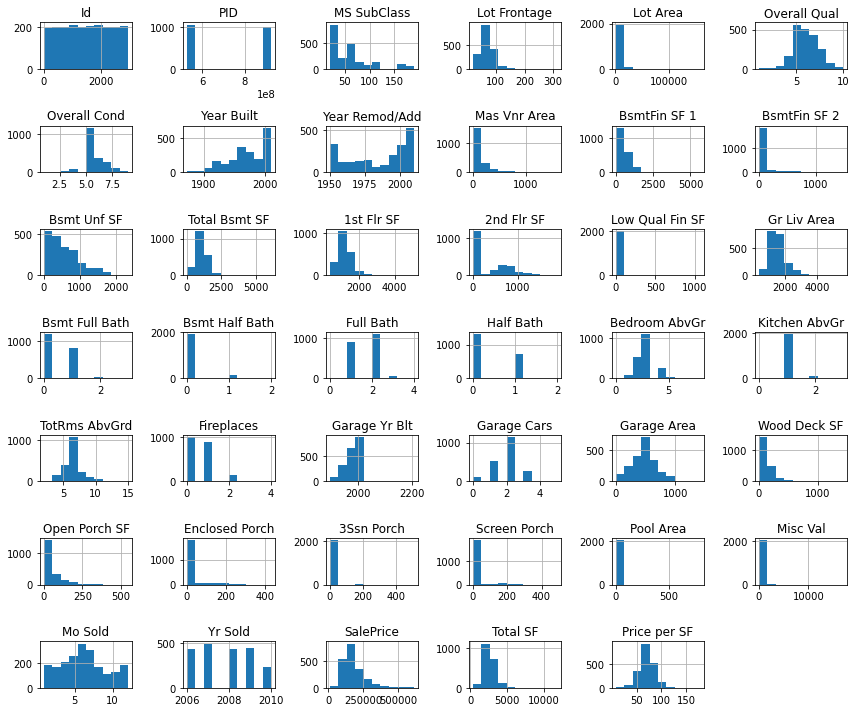

In [10]:
df.hist(figsize = (12, 10));
plt.tight_layout();

---

# Feature Selection
Choose the most predictive variables to include in a Linear Regression model.

#### What is the relationship between `Neighborhood` and `Sale Price`?

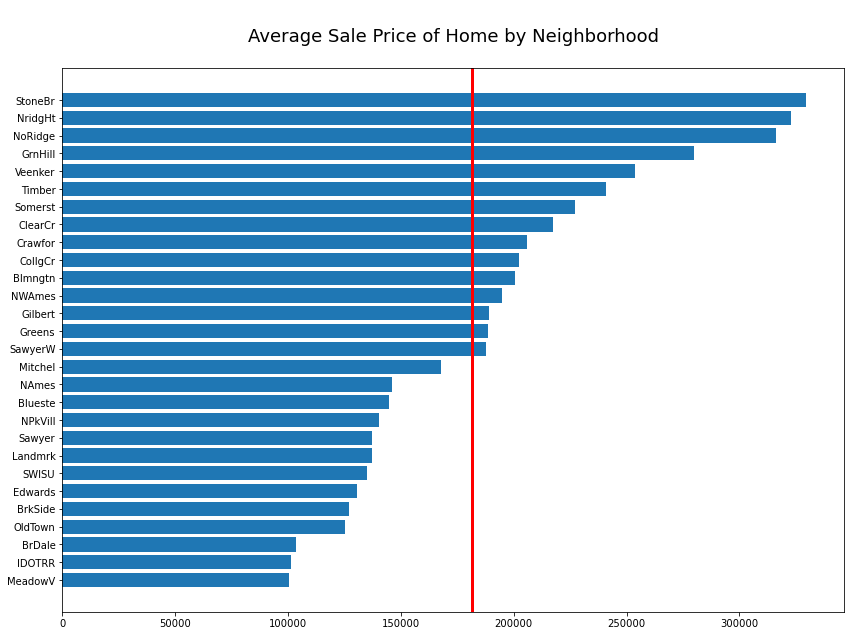

In [11]:
groups = df.groupby('Neighborhood')[['SalePrice']].mean().sort_values('SalePrice')

plt.figure(figsize=(14, 10))
plt.barh(width = groups['SalePrice'].values, y = groups.index)
plt.axvline(x = df['SalePrice'].mean(), color = 'red', linewidth = 3)
plt.title("\nAverage Sale Price of Home by Neighborhood\n", fontsize = 18)
plt.show()

The red line indicates the mean home sale price of all houses in this dataset. Everything to the right of that line is above average. The wealthiest neighborhoods are Stone Brook, Northridge Heights, and Northridge. The cheapest are Briardale, Iowa DOT & Railroad, and Meadow Village. It is likely that `Neighborhood` has some predictive impact on the target variable, `Sale Price`.

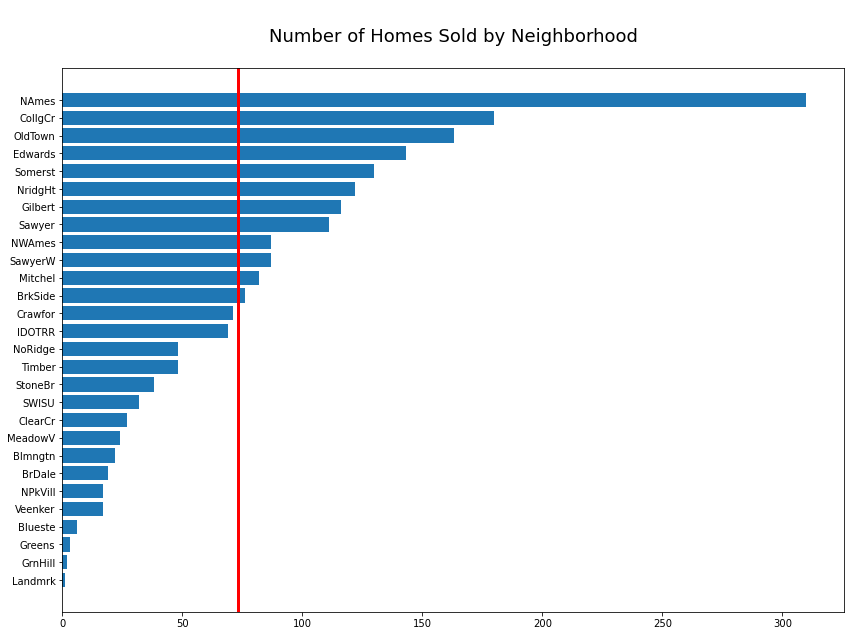

In [12]:
plt.figure(figsize=(14, 10))
plt.barh(width = df['Neighborhood'].value_counts().values, y = df['Neighborhood'].value_counts().index)
plt.axvline(x = df['Neighborhood'].value_counts().mean(), color = 'red', linewidth = 3)
plt.title("\nNumber of Homes Sold by Neighborhood\n", fontsize = 18)
plt.gca().invert_yaxis()
plt.show()

However, you can see the number of houses sold varies signficantly from `Sale Price`. Not as many homes are being sold in expensive neighborhoods. The neighborhood with the most turnover (by far) is North Ames.

#### `Building Type` is relative within neighborhoods

In [13]:
# Single-family Detached homes have the highest sale price
df.groupby('Bldg Type')[['SalePrice']].mean().sort_values('SalePrice', ascending = False)

,SalePrice
Bldg Type,
TwnhsE,198312.372671
1Fam,185275.685882
Duplex,139296.333333
Twnhs,133100.000000
2fmCon,123179.891304


In [14]:
def avg_price_subcategory(neighborhood, subcategory):
    
    # Extract every subcategory within this neighborhood
    location, count = zip(*df[df['Neighborhood']==neighborhood][[subcategory]].value_counts().items())
    var_list = {}
    
    # For number of subcategorical values present
    for i, item in enumerate(location):
        
        # Unpack subcategory value from tuple
        category = list(list(location[i]))[0]
        
        # Get the average sale price for that subcategory within the neighborhood
        avg_price = df[(df['Neighborhood']==neighborhood) & (df[subcategory]==category)]['SalePrice'].mean()
        
        # Add to dictionary of average prices in the neighborhood
        var_list[category] = round(avg_price, 2)
    
    # Return dictionary sorted by highest prices
    return (dict(sorted(var_list.items(), key=lambda item: item[1], reverse=True)))

In [15]:
subcategory = 'Bldg Type'

for neighborhood in df['Neighborhood'].unique():
    s = (f"{neighborhood} = {avg_price_subcategory(neighborhood, subcategory)}")
    print(s)

Sawyer = {'1Fam': 137852.31, 'Duplex': 131815.57, '2fmCon': 127133.33}
SawyerW = {'1Fam': 194214.41, 'Duplex': 173245.67, 'TwnhsE': 140957.14}
NAmes = {'TwnhsE': 183000.0, '1Fam': 147212.29, '2fmCon': 142225.0, 'Duplex': 126084.0}
Timber = {'TwnhsE': 241500.0, '1Fam': 241041.81}
Edwards = {'TwnhsE': 140100.0, 'Twnhs': 133833.33, '1Fam': 131684.19, 'Duplex': 125092.86, '2fmCon': 106380.0}
OldTown = {'1Fam': 126731.76, '2fmCon': 115800.0, 'Duplex': 98666.67}
BrDale = {'TwnhsE': 105833.33, 'Twnhs': 102909.38}
CollgCr = {'1Fam': 205036.91, 'Duplex': 185000.0, 'TwnhsE': 142592.86}
Somerst = {'1Fam': 247695.44, 'TwnhsE': 196077.97, 'Twnhs': 169638.46}
Mitchel = {'1Fam': 168890.0, '2fmCon': 168000.0, 'Twnhs': 164000.0, 'Duplex': 163250.0, 'TwnhsE': 159666.67}
StoneBr = {'1Fam': 425513.9, 'TwnhsE': 223188.89}
NridgHt = {'1Fam': 353456.27, 'TwnhsE': 250794.44, 'Twnhs': 186357.14}
Gilbert = {'1Fam': 189916.61, '2fmCon': 150000.0}
Crawfor = {'TwnhsE': 298280.57, '1Fam': 198067.03, 'Duplex': 17500

These averages show that while `Neighborhood` is the clearly the primary determining factor of `SalePrice`, within each neighborhood, Single Family homes sell for the highest price, followed closely by townhouses.

#### The `Zoning` of a property greatly affects the price per square foot

In [16]:
# Create a function to make the categories in MS Zoning column more readable
zones = {'RL':'res_lo_dens', 'RM':'res_md_dens', 'FV':'res_float_vil', "C (all)":'commercial',
           'RH':'res_hi_dens', "A (agr)":'agricultural', "I (all)":'industrial'}

df['MS Zoning'] = df['MS Zoning'].apply(lambda x: zones[x] if x in zones else None)

In [17]:
zoning = df.groupby(by='MS Zoning')[['MS Zoning', 'Price per SF']].mean()
zoning = zoning.sort_values('Price per SF', ascending=True)
zoning

,Price per SF
MS Zoning,
agricultural,34.404630
commercial,47.179216
res_hi_dens,58.363312
res_md_dens,61.711228
industrial,71.141975
res_lo_dens,71.842303
res_float_vil,83.122093


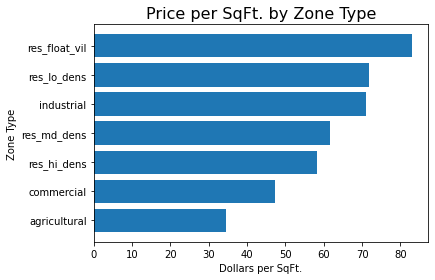

In [18]:
plt.barh(y=list(zoning.index.ravel()), width=list(zoning['Price per SF']));
plt.title("Price per SqFt. by Zone Type", fontsize=16)
plt.xlabel('Dollars per SqFt.');
plt.ylabel('Zone Type');

#### Does `Garage Type` affect price?

In [19]:
garages = df.groupby(by='Garage Type')[['Garage Type', 'SalePrice']].mean()
garages = garages.sort_values('SalePrice', ascending=True)
garages

,SalePrice
Garage Type,
CarPort,103823.545455
Detchd,132132.947761
Basment,143242.333333
2Types,157184.210526
Attchd,205040.195383
BuiltIn,247883.522727


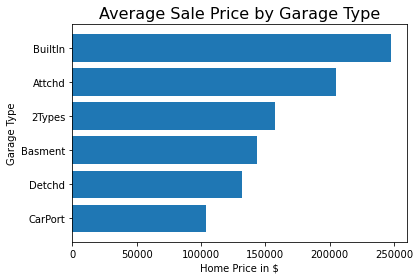

In [20]:
plt.barh(y=list(garages.index.ravel()), width=list(garages['SalePrice']));
plt.title("Average Sale Price by Garage Type", fontsize=16)
plt.xlabel('Home Price in $');
plt.ylabel('Garage Type');

According to these averages, homes with Built-in and Attached garages sell at a higher price point than those with a Detached garage or Car Port.

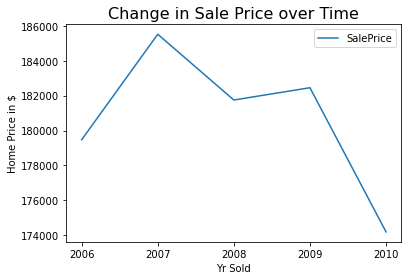

In [21]:
# Plot a line graph of the average sale price by Year Sold
year_sold = df.groupby(by='Yr Sold')[['SalePrice']].mean().sort_values(by = 'SalePrice', ascending=False)
year_sold = year_sold.sort_index()
year_sold.plot(kind='line', y='SalePrice')
plt.xticks(range(2006, 2011, 1));
plt.title("Change in Sale Price over Time", fontsize=16)
plt.ylabel('Home Price in $');

Since there seems to be a significant fluctuation of price over time, it might make sense to dummify this variable.

#### Formulas to quantify categorical rating scales

In [22]:
# Map categorical rating scales (Excellent, Good, Average, Fair, Poor) to numerical values
def qual_cond_scale(obj):
    if obj == 'Ex':
        return 5
    elif obj == 'Gd':
        return 4
    elif obj == 'TA':
        return 3
    elif obj == 'Fa':
        return 2
    elif obj == 'Po':
        return 1
    else:
        return 0
    
# BsmtFin Type 1 & Garage Finish column
def finish_scale(obj):
    if obj == 'GLQ':
        return 6
    elif obj == 'ALQ':
        return 5
    elif obj == 'BLQ':
        return 4
    elif obj == 'Rec' or obj == 'Fin':
        return 3
    elif obj == 'LwQ'or obj == 'RFn':
        return 2
    elif obj == 'Unf' or obj == 'Unf':
        return 1
    else:
        return 0
    
def func_scale(obj):
    if obj == 'Typ':
        return 7
    elif obj == 'Min1':
        return 6
    elif obj == 'Min2':
        return 5
    elif obj == 'Mod':
        return 4
    elif obj == 'Maj1':
        return 3
    elif obj == 'Maj2':
        return 2
    elif obj == 'Sev':
        return 1
    elif obj == 'Sal':
        return 0
    else:
        return np.nan
    
# Create a custom feature that combines several quality & condition variables
def merge_loc(col_list):
    location_sum = []
    for col in col_list:
        location_sum.append(df[col] / df[col].mean())
        
    return round(sum(location_sum), 4)

# Condense categorical location variables to either "Near Road", "Near Rail",  or "Near Amenity"
def location_vars(obj):
    if obj == 'RRNn' or obj == 'RRAn' or obj == 'RRNe' or obj == 'RRAe':
        return 'near_rail'
    elif obj == 'Artery' or obj == 'Feedr':
        return 'near_road'
    elif obj == 'PosN' or obj == 'PosA':
        return 'near_amenity'
    else:
        return None

In [23]:
df['Condition 1'] = df['Condition 1'].apply(location_vars)
df['Condition 2'] = df['Condition 2'].apply(location_vars)

--- 
## Plot correlation matrices to identify collinearity

In [24]:
cols_to_drop = ['SalePrice', 'Mo Sold', 'Yr Sold', 'Id', 'PID', 'MS SubClass', 'MS Zoning',
                'Year Built', 'Garage Yr Blt', 'Year Remod/Add', 'Sale Type', 'Misc Val',
                'Overall Qual', 'Overall Cond']
cols_to_plot = [col for col in df.columns if col not in cols_to_drop]

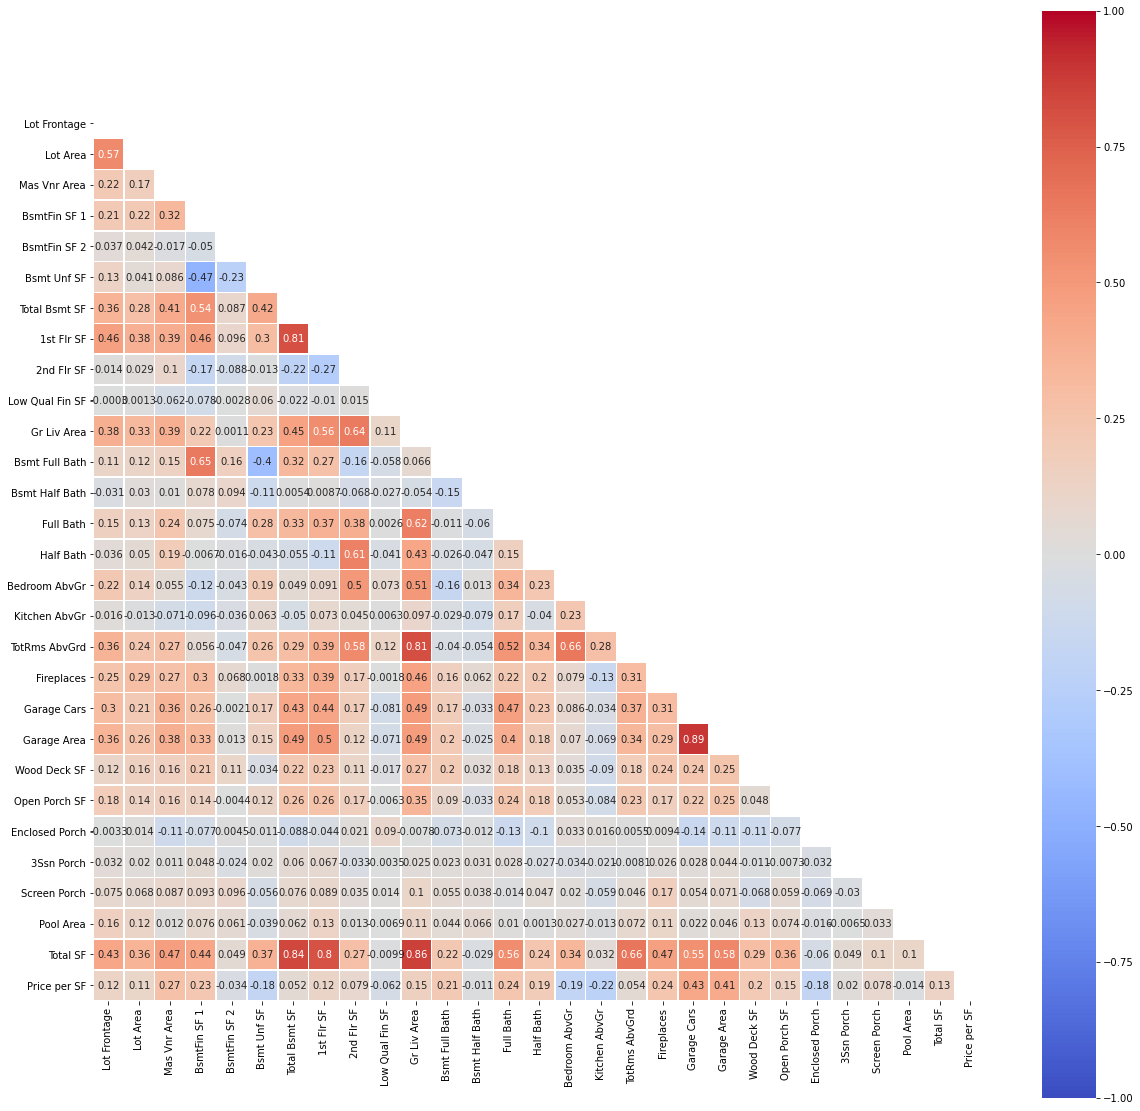

In [25]:
plt.figure(figsize=(20,20))
corr = df[cols_to_plot].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1, annot=True, square = True,
            linecolor="white", linewidths=.5, mask = mask);

This correlation matrix shows that there's a strong collinearity between the `Garage Cars` and `Garage Area` variables, so I can probably drop one of those features. There seems to be a similar collinearity between `Gr Lv Area` and `TotRms AbvGrd`. Conversely, the most negative correlations are between `BsmtFin SF1`, `Bsmt Unf SF`, and `Bsmt Full Bath`. Some of these variables are evidently redundant, so we can drop them before instantiating our Linear Regression model.

In [26]:
#Encode categorical ratings to numeric scales
qual_cond_transform = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Heating QC', 'Kitchen Qual',
                       'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Bsmt Cond'] 

for col in qual_cond_transform:
    df[col] = df[col].apply(qual_cond_scale)

df['BsmtFin Type 1'] = df['BsmtFin Type 1'].apply(finish_scale)
df['Garage Finish'] = df['Garage Finish'].apply(finish_scale)
df['Functional'] = df['Functional'].apply(func_scale)

In [27]:
# Engineer a set of features to serve as a proxy for Neighborhood variable
df['Loc Score'] = merge_loc(df[['Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Functional']])

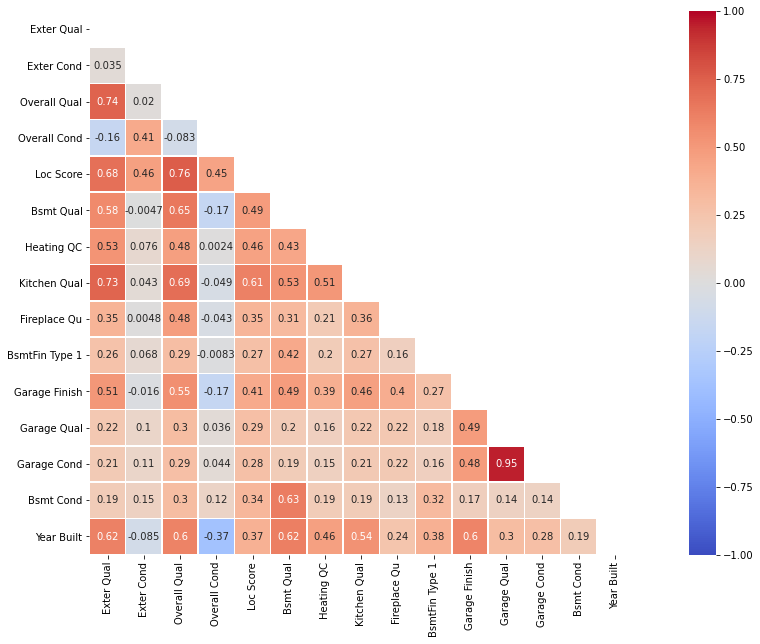

In [28]:
cols = ['Exter Qual', 'Exter Cond', 'Overall Qual', 'Overall Cond', 'Loc Score', 'Bsmt Qual', 'Heating QC',
        'Kitchen Qual', 'Fireplace Qu', 'BsmtFin Type 1', 'Garage Finish', 'Garage Qual', 'Garage Cond',
        'Bsmt Cond', 'Year Built']

plt.figure(figsize=(20,10))
corr = df[cols].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1, annot=True, square = True,
            linecolor="white", linewidths=.5, mask = mask);

According to this correlation matrix, there appears to be strong collinearity between the `Garage Qual` and `Garage Cond` variables, (as well as `Bsmt Qual` and `Bsmt Cond` to a lesser extent), so I can probably drop one of the features from both pairs.

In [29]:
# Re-run all columns with numeric values
numeric = [col for col in df.columns if df.dtypes[col]==int or df.dtypes[col]==float]
numeric.remove('Id')
numeric.remove('PID')
numeric.remove('MS SubClass')

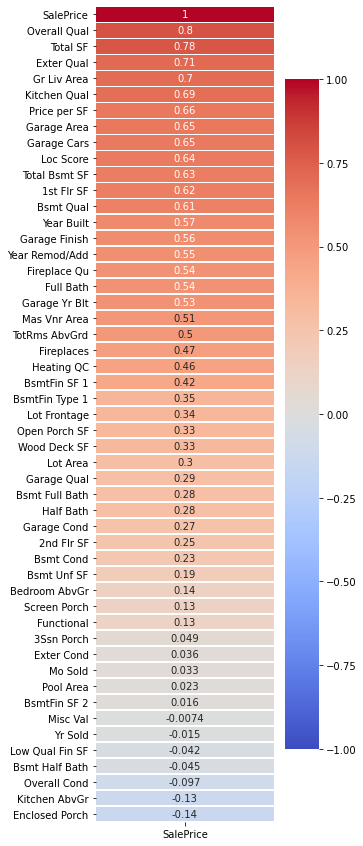

In [30]:
plt.figure(figsize=(4,15))
corr = df[numeric].corr()
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending = False),
            cmap='coolwarm', vmax=1, vmin=-1, annot=True, linecolor="white", linewidths=.5);

From the above heatmap, the features most positively correlated with the target variable `SalePrice` are `Overall Qual`, `Exter Qual`, `Gr Liv Area`, `Garage Area/Cars`, `Total Bsmt SF`, and `1st Flr SF`. Conversely, we can probably drop `Exter Cond`, `Overall Cond`, and `Bsmt Half Bath`.

---
# Scatterplots to Look for Patterns in Categorical Data

#### Determine the impact of `Year Built` (if any) on `Sale Price`.

<Figure size 864x720 with 0 Axes>

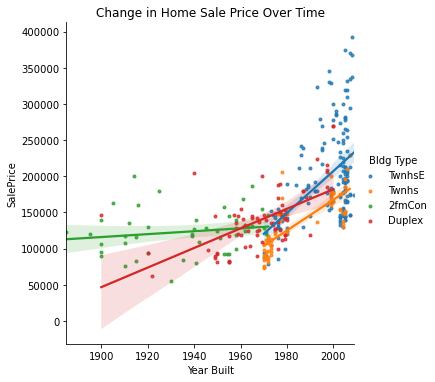

In [31]:
mask = df['Bldg Type']=='TwnhsE'
mask_2 = df['Bldg Type']=='Twnhs'
mask_3 = df['Bldg Type']=='Duplex'
mask_4 = df['Bldg Type']=='2fmCon'

plt.figure(figsize=(12,10));
sns.lmplot(x='Year Built', y='SalePrice', data=df[mask | mask_2 | mask_3 | mask_4], hue='Bldg Type', markers='.');
plt.title("Change in Home Sale Price Over Time");

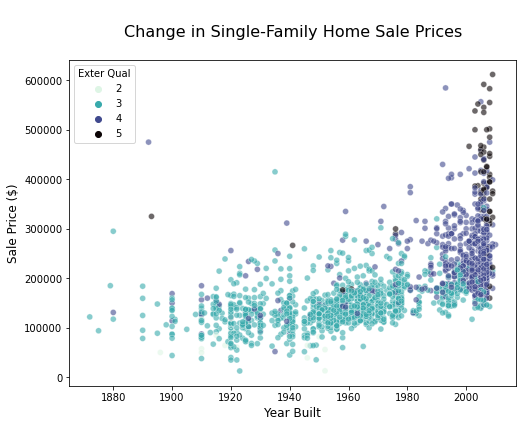

In [32]:
mask = df['Bldg Type']=='1Fam'

plt.figure(figsize=(8,6));
sns.scatterplot(x='Year Built', y='SalePrice', data=df[mask], alpha=.6, hue='Exter Qual', palette='mako_r');
plt.title("\nChange in Single-Family Home Sale Prices\n", fontsize=16);
plt.xlabel('Year Built', fontsize=12);
plt.ylabel('Sale Price ($)', fontsize=12);

There seems to be a significant uptick in home prices across all building types since the year 2000. `Exterior Quality` (aka curb appeal), has also become a more significantly predictive variable in home prices since the late 1990's.

#### Determine the impact of continous variables (such as square footage) on `Sale Price`

In [33]:
df.groupby('Kitchen Qual')[['SalePrice']].mean().sort_values('SalePrice', ascending = False)

,SalePrice
Kitchen Qual,
5,336424.463576
4,211629.451613
3,139501.607450
2,101334.957447


Homes with a better kitchen quality definitely sell at a higher price point.

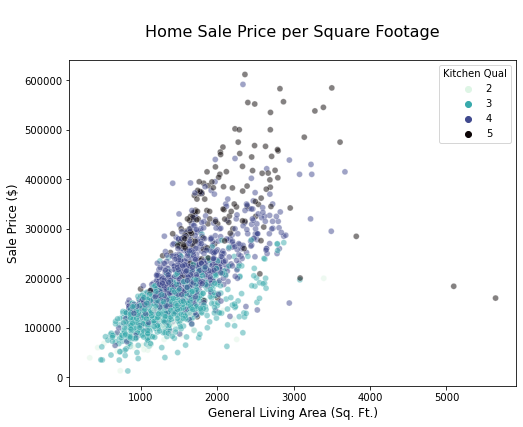

In [34]:
plt.figure(figsize=(8,6));
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df, alpha=.5, hue='Kitchen Qual', palette='mako_r');
plt.title("\nHome Sale Price per Square Footage\n", fontsize=16);
plt.xlabel('General Living Area (Sq. Ft.)', fontsize=12);
plt.ylabel('Sale Price ($)', fontsize=12);

`General Living Area` does correlate positively with `Sale Price`, and `Kitchen Qual` has noticeable stratification among rating groups.

### Identify Outliers

/Users/apascale/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


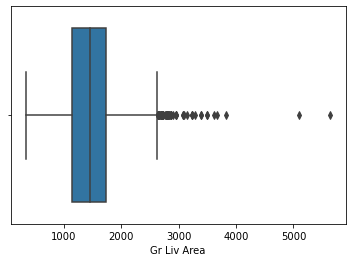

In [35]:
# There are two outliers of homes with 5,000+ sq ft
sns.boxplot(df['Gr Liv Area']);

In [36]:
# And a few outliers of houses that have 0 or 3 kitchens
df[(df['Kitchen AbvGr'] > 2) | (df['Kitchen AbvGr'] < 1)][['Kitchen AbvGr', 'SalePrice']]

,Kitchen AbvGr,SalePrice
1137,0,127500
1359,3,106000
1519,0,127500
